<h2>東北大BERTの検証</h2>

<h3>説明</h3>
東北大BERTが研究に適しているか，自由記述文のスコア付けタスクを行うことにより検証する．


<h3>コード記述</h3>

In [44]:
!pip -q install transformers fugashi ipadic japanize-matplotlib

In [45]:
from transformers import AutoModel, AutoTokenizer
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from sklearn.manifold import TSNE
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity

In [46]:
# 事前学習済みモデルの読み込み
tokenizer = AutoTokenizer.from_pretrained("cl-tohoku/bert-base-japanese")
model = AutoModel.from_pretrained("cl-tohoku/bert-base-japanese")

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [47]:
import requests
from bs4 import BeautifulSoup
import random

book_id = '773'
res = requests.get("https://www.aozora.gr.jp/cards/000148/files/773_14560.html")

html_content = res.content.decode("shift-jis")
soup = BeautifulSoup(html_content, 'html.parser')

# タグとその内容の削除
for tag in soup.find_all(["rt", "rp"]):
    tag.decompose()

main_text = soup.find('div', {'class': 'main_text'}).get_text()
clean_text = main_text.replace('\r', '').replace('\n', '').replace('\u3000', '')
text_list = clean_text.split('。')

# N個のランダムな行を取得します
N = 1000
texts = random.sample(text_list, N)
texts = [text + "。" for text in texts]

# 結果を表示します
print("ランダムな行のリスト:")
print(texts)

ランダムな行のリスト:
['作さんは丈夫で羨ましいね。', 'こういう過去を二人の間に通り抜けて来ているのですから、精神的に向上心のないものは馬鹿だという言葉は、Ｋに取って痛いに違いなかったのです。', 'つまり二人は暑さのため、潮のため、また歩行のため、在来と異なった新しい関係に入る事ができたのでしょう。', 'それからその中で面白そうなものを四、五幅裸にして行李の底へ入れて来ました。', '「いいえ」「どなたのお墓があるんですか。', '「今のうち何か聞いておく必要はないかな」と兄が私の顔を見た。', 'けれども実際彼の母が病気であるとすれば彼は固より帰るべきはずであった。', '客も誰も来ないのに、内々の小人数だけで取ろうという歌留多ですからすこぶる静かなものでした。', '横浜から船に乗る人が、朝八時半の汽車で新橋を立つのはその頃の習慣であった。', '常よりは晴やかな調子で、「これから六月までは一番気楽な時ですね。', '何も知らない妻は次の室で無邪気にすやすや寝入っています。', '私が父の病気をよそに、静かに坐ったり書見したりする余裕のあるごとくに、母も眼の前の病人を忘れて、外の事を考えるだけ、胸に空地があるのかしらと疑った。', 'ただ何事もいえなかったのです。', '私はＫの頭のどこか一カ所を突き破って、そこから柔らかい空気を吹き込んでやりたい気がしました。', '彼は迷惑そうでした。', '私は何か急用でもできたのかとお嬢さんに聞き返しました。', 'けれどもこういう用件で先生にせまるのは私の苦痛であった。', '私は心のうちで、その口は到底私の頭の上に落ちて来ないと思っていた。', '休みが来れば帰らなくてはならないという気分は、いくら東京を恋しがって出て来た私にも、力強くあったのです。', 'その日取りのまだ来ないうちに、ある大きな事が起った。', 'その上私は国へ帰るたびに、父にも母にも解らない変なところを東京から持って帰った。', '私の頭はいくら歩いてもＫの事でいっぱいになっていました。', 'しかし片方の音楽になると花よりももっと変でした。', '私は露次を抜けたり、横丁を曲ったり、ぐるぐる歩き廻りました。', '先生はそれを落すために、後ろ向きになって、浴衣を二、三度振った。', '玄関を上がって私のいる所へ通ろうとするには、ぜひこ

In [48]:


# 特徴ベクトルを取得
features_list = []
for text in tqdm(texts):
    inputs = tokenizer(text, return_tensors="pt")
    outputs = model(**inputs)
    features = outputs.last_hidden_state.mean(dim=1).squeeze().detach().numpy()
    # ノルムを1に正規化
    features_norm = np.linalg.norm(features)
    if features_norm > 0:
        features = features / features_norm
    features_list.append(features)

# 特徴ベクトルをnumpy配列に変換
features_array = np.array(features_list)

# 重心を計算
center = features_array[0]

# 特徴量と中心点のコサイン類似度を計算
similarities = cosine_similarity(features_array, center.reshape(1, -1)).flatten()

# 類似度が高い順にデータをソート
sorted_indices = similarities.argsort()[::-1]

for i, text in enumerate(np.array(texts)[sorted_indices]):
    print(f'No.{i}: {text}')

100%|██████████| 1000/1000 [01:56<00:00,  8.58it/s]

No.0: 作さんは丈夫で羨ましいね。
No.1: 「仲が好さそうですね」と私が答えた。
No.2: 「関さんも気の毒だね。
No.3: そうだなあと低い声で渋っています。
No.4: 奥さんは私を静かな人、大人しい男と評しました。
No.5: 叔父さん、今日はって、断ってはいって来ると好かったのに」先生は苦笑した。
No.6: 「お前の卒業祝いは已めになって結構だ。
No.7: 関さんよりも兄さんの方が困るでしょう、こう長くなっちゃ」「困っても仕方がない。
No.8: 母は強い熱に堪え得る体質の女なんでしたろうか、叔父は「確かりしたものだ」といって、私に向って母の事を褒めていました。
No.9: 奥さんはそれでも丈夫そうになったといって賞めてくれるのです。
No.10: 私はかつて先生から「あなたの宅の構えはどんな体裁ですか。
No.11: 俸給が豊かでなくって、やむをえず素人屋に下宿するくらいの人だからという考えが、それで前かたから奥さんの頭のどこかにはいっていたのでしょう。
No.12: 先生の笑いは、「世間はこんな場合によくお目出とうといいたがるものですね」と私に物語っていた。
No.13: 「こんど東京へ行くときには椎茸でも持って行ってお上げ」「ええ、しかし先生が干した椎茸なぞを食うかしら」「旨くはないが、別に嫌いな人もないだろう」私には椎茸と先生を結び付けて考えるのが変であった。
No.14: すると上さんがまた、「素人下宿じゃいけませんか」と聞くのです。
No.15: ただ頭というのはあまりに冷やか過ぎるから、私は胸といい直したい。
No.16: 常よりは晴やかな調子で、「これから六月までは一番気楽な時ですね。
No.17: むしろ愉快に感じたくらいです。
No.18: 外へ出ると大変好い心持です」「どこへ」私はどこでも構わなかった。
No.19: その頃の私はまだ癇癪持ちでしたから、そう不真面目に若い女から取り扱われると腹が立ちました。
No.20: 「大病は好いが、ちょっとした風邪などはかえって厭なものですね」といった先生は、苦笑しながら私の顔を見た。
No.21: 「今斥候長になってるところなんだよ」小供はこう断って、躑躅の間を下の方へ駈け下りて行った。
No.22: その後をまた強い日で照り付けられるのですから、身体が倦怠くてぐたぐたになりまし

In [49]:
# T-SNEによる次元圧縮 
features_list.append(center)
tsne = TSNE(n_components=2) # n_componentsは低次元データの次元数
features_tsne = tsne.fit_transform(np.array(features_list))

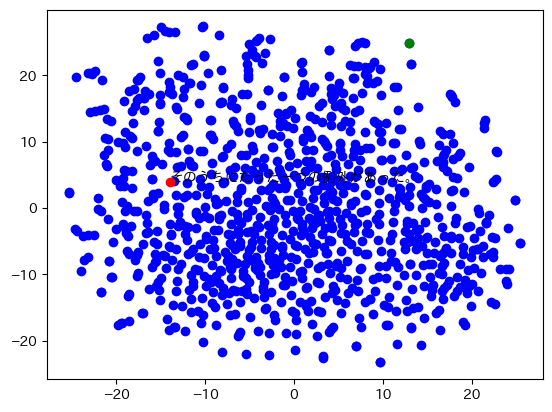

In [50]:
for i in range(len(features_list)-1):
    plt.scatter(
        features_tsne[i, 0],
        features_tsne[i, 1],
        color="blue" if i != sorted_indices[-1] else "red")
plt.scatter(
        features_tsne[len(features_list)-1, 0],
        features_tsne[len(features_list)-1, 1],
        color="green")
plt.text(
    features_tsne[sorted_indices[-1], 0] - 0.1,
    features_tsne[sorted_indices[-1], 1] + 0.05,
    texts[sorted_indices[-1]],
    color="black")
plt.show()